# RFM Analysis

This iPython notebook explains how to perform RFM analysis from customer purchase history data. The sample orders file is Sample - Superstore dataset from Tableau Software.

If you have suggestions or improvements please contribute on https://github.com/joaolcorreia/RFM-analysis

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Read the sample orders file, containing all past purchases for all customers.

In [2]:
orders = pd.read_csv('sample-orders.csv',sep=',')

In [3]:
orders.head()

,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franz�sisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21


## Create the RFM Table

Since recency is calculated for a point in time and the Tableau Super Store dataset last order date is Dec 31 2014, that is the date we will use to calculate recency.

Set this date to the current day and extract all orders until yesterday.

In [4]:
import datetime as dt
NOW = dt.datetime(2014,12,31)

In [5]:
# Make the date_placed column datetime
orders['order_date'] = pd.to_datetime(orders['order_date'])

Create the RFM Table

In [6]:
rfmTable = orders.groupby('customer').agg({'order_date': lambda x: (NOW - x.max()).days, # Recency
                                        'order_id': lambda x: len(x),      # Frequency
                                        'grand_total': lambda x: x.sum()}) # Monetary Value

rfmTable['order_date'] = rfmTable['order_date'].astype(int)
rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'}, inplace=True)

## Validating the RFM Table

In [7]:
rfmTable.head()

,recency,frequency,monetary_value
customer,,,
Aaron Bergman,415,3,887
Aaron Hawkins,12,7,1744
Aaron Smayling,88,7,3050
Adam Bellavance,54,8,7756
Adam Hart,34,10,3249


Customer **Aaron Bergman** has frequency:3, monetary value:$887 and recency:415 days.

In [8]:
aaron = orders[orders['customer']=='Aaron Bergman']
aaron

,order_date,order_id,customer,grand_total
624,2011-02-19,CA-2011-152905,Aaron Bergman,13
665,2011-03-07,CA-2011-156587,Aaron Bergman,310
2336,2013-11-11,CA-2013-140935,Aaron Bergman,564


Inserting the date of Aaron purchase and comparing it to the recency in the rfmTable we verify our RFM table is correct.

In [9]:
(NOW - dt.datetime(2013,11,11)).days==415

True

## Determining RFM Quartiles

In [10]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [11]:
quantiles

,recency,frequency,monetary_value
0.25,30.0,5.0,1145.0
0.50,75.0,6.0,2257.0
0.75,183.0,8.0,3784.0


Send quantiles to a dictionary, easier to use.

In [12]:
quantiles = quantiles.to_dict()

In [13]:
quantiles

{'recency': {0.25: 30.0, 0.5: 75.0, 0.75: 183.0},
 'frequency': {0.25: 5.0, 0.5: 6.0, 0.75: 8.0},
 'monetary_value': {0.25: 1145.0, 0.5: 2257.0, 0.75: 3784.0}}

## Creating the RFM segmentation table

In [14]:
rfmSegmentation = rfmTable

We create two classes for the RFM segmentation since, being high recency is bad, while high frequency and monetary value is good. 

In [15]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1


In [16]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))

In [17]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [18]:
rfmSegmentation.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Aaron Bergman,415,3,887,4,4,4,444
Aaron Hawkins,12,7,1744,1,2,3,123
Aaron Smayling,88,7,3050,3,2,2,322
Adam Bellavance,54,8,7756,2,2,1,221
Adam Hart,34,10,3249,2,1,2,212


In [19]:
# Uncomment any of the following lines to: copy data to clipboard or save it to a CSV file.
# rfmSegmentation.to_clipboard()
# rfmSegmentation.to_csv('rfm-table.csv', sep=',')

Who are the top 5 best customers? by RFM Class (111), high spenders who buy recently and frequently?

In [21]:
rfmSegmentation[rfmSegmentation['RFMClass']=='111'].sort_values('monetary_value', ascending=False).head(5)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Sanjit Engle,9,11,12210,1,1,1,111
John Lee,21,11,9801,1,1,1,111
Pete Kriz,9,12,8647,1,1,1,111
Harry Marie,2,10,8237,1,1,1,111
Lena Creighton,16,12,7661,1,1,1,111


# key RFM segments

1.Best Customers: RFMClass=111	
Customers who bought most recently, most often and spend the most.	No price incentives, New products and loyalty programs 

2.Loyal Customers: RFMClass=X1X	
Customers who bought most recently	Use R and M to further segment.

3.Big Spenders:RFMClass=XX1	
Customers who spend the most	Market your most expensive products.

4.Almost Lost:RFMClass=311
Haven't purchased for some time, but purchased frequently and spend the most.	Agressive price incentives

5.Lost Customers: RFMClass=411	
Haven't purchased for some time, but purchased frequently and spend the most.	Agressive price incentives.

6.Lost Cheap Customers:RFMClass=444	
Last purchase long ago, purchased few and spend little.	Don't spend too much trying to re-acquire.

In [37]:
# Best Customers: RFMClass=111
bc_Segment=rfmSegmentation.loc[rfmSegmentation['RFMClass']=='111']
# Loyal Customers: RFMClass=X1X
lc_Segment=rfmSegmentation.loc[(rfmSegmentation['R_Quartile']!=1)&(rfmSegmentation['F_Quartile']==1)&(rfmSegmentation['M_Quartile']!=1)]
# Big Spenders: RFMClass=XX1
bs_Segment=rfmSegmentation.loc[(rfmSegmentation['R_Quartile']!=1)&(rfmSegmentation['F_Quartile']!=1)&(rfmSegmentation['M_Quartile']==1)]
# Almost Lost: RFMClass=311
al_Segment=rfmSegmentation.loc[rfmSegmentation['RFMClass']=='311']
# Lost Customers: RFMClass=411
loc_Segment=rfmSegmentation.loc[rfmSegmentation['RFMClass']=='411']
# Lost Cheap Customers: RFMClass=444
lcc_Segment=rfmSegmentation.loc[rfmSegmentation['RFMClass']=='444']
lcc_Segment.head(5)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Aaron Bergman,415,3,887,4,4,4,444
Alyssa Crouse,232,3,926,4,4,4,444
Anemone Ratner,534,1,88,4,4,4,444
Anna Chung,282,5,658,4,4,4,444
Anthony O'Donnell,501,1,161,4,4,4,444


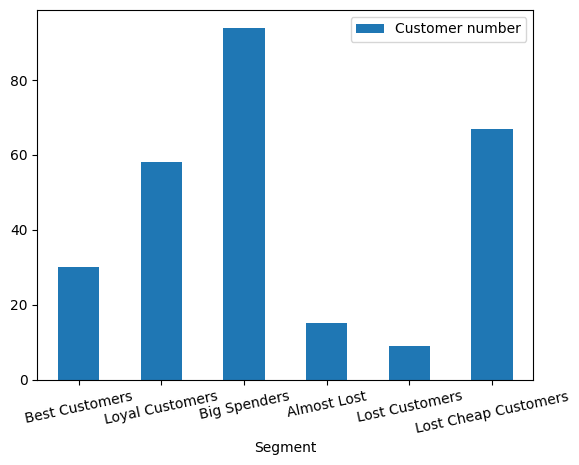

In [46]:
df = pd.DataFrame({'Segment':['Best Customers', 'Loyal Customers', 'Big Spenders','Almost Lost','Lost Customers','Lost Cheap Customers'],
                   'Customer number':[bc_Segment.shape[0], 
                                      lc_Segment.shape[0],
                                      bs_Segment.shape[0],
                                      al_Segment.shape[0],
                                      loc_Segment.shape[0],
                                     lcc_Segment.shape[0]]})
ax = df.plot.bar(x='Segment', y='Customer number', rot=12)